# Installations

In [1]:
# install required packages
%pip install pydicom matplotlib rt_utils numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:00a 0:00:01
  Using cached matplotlib-3.7.1-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached Pillow-9.5.0-cp39-cp39-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached contourpy-1.0.7-cp39-cp39-macosx_10_9_x86_64.whl (244 kB)
  Using cached numpy-1.24.3-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import required packages
import pydicom # pydicom is a package for working with DICOM files such as medical images, reports, and radiotherapy objects
import os # os module provides functions for interacting with the operating system
import matplotlib.pyplot as plt # matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
import numpy as np # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
from rt_utils import RTStructBuilder # rt_utils is a package for working with DICOM RT structure sets
import re # re module provides regular expression matching operations

# Testing and familiarisation

In [4]:
dicom_dir = "dataset/manifest-MjbMt99Q1553106146386120388/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623/11.000000-AXIAL SE T1 - RESEARCH-12555/"
rtstruct_dir = "dataset/manifest-MjbMt99Q1553106146386120388/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623/1.000000-RTstructT1-64320/1-1.dcm"

In [5]:
# Load a single DICOM file
dcm = pydicom.dcmread(dicom_dir + "1-01.dcm")
# Print some attributes
print(dcm.PatientID)
print(dcm.Modality)


STS_001
MR


['GTV_Mass', 'GTV_Edema']


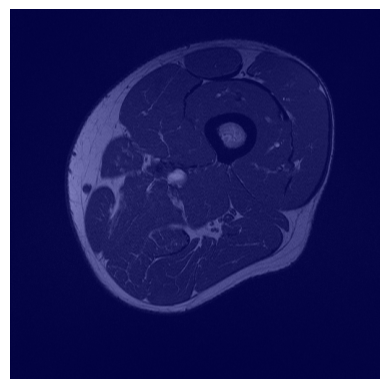

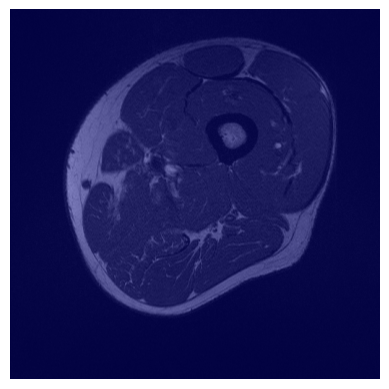

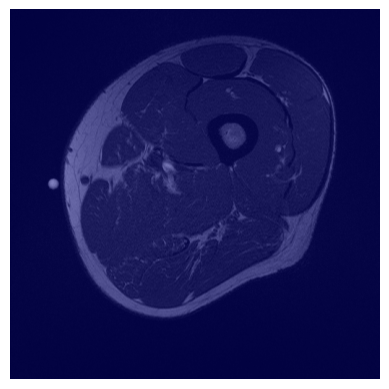

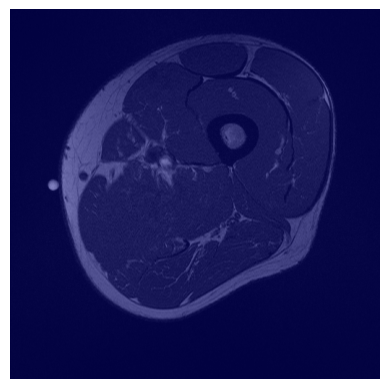

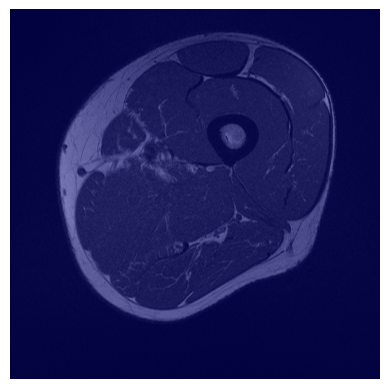

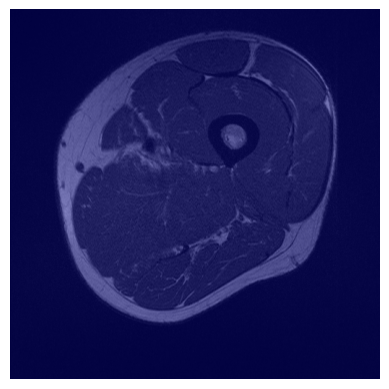

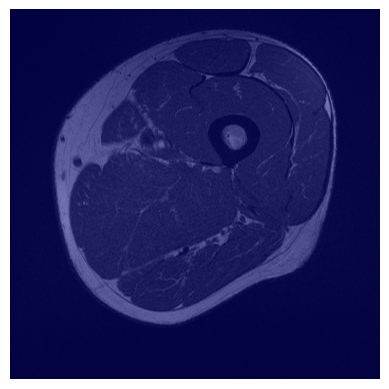

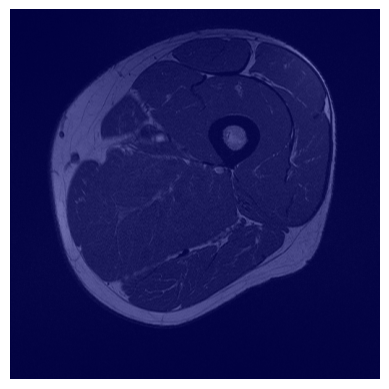

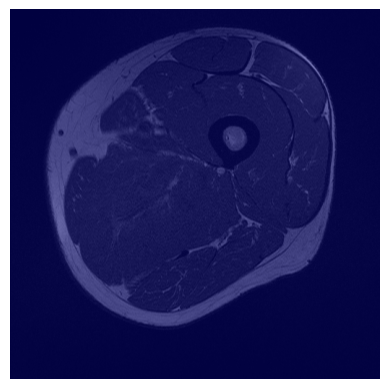

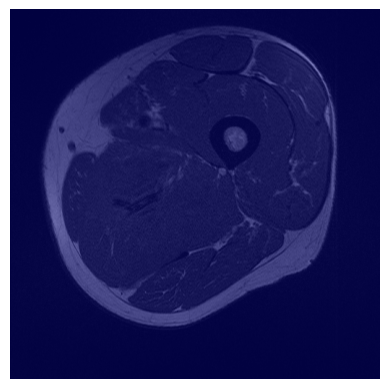

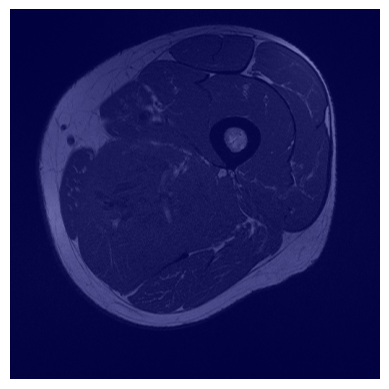

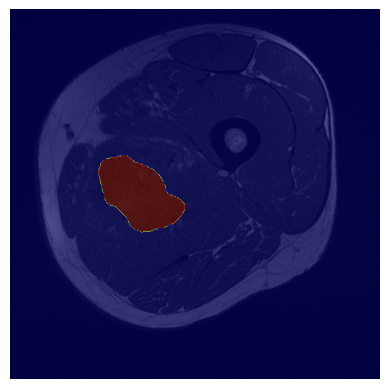

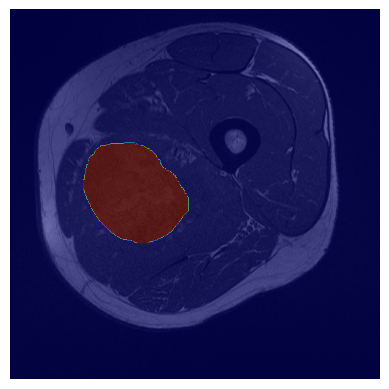

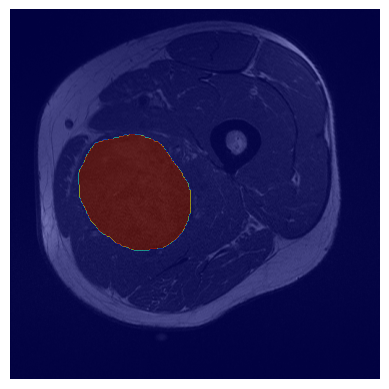

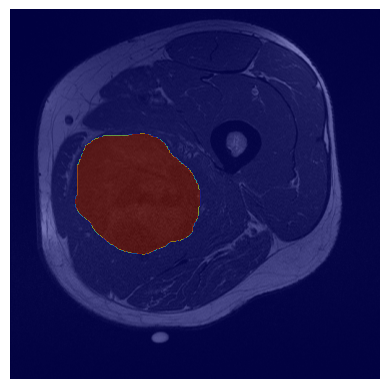

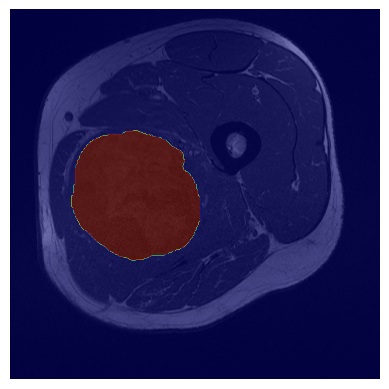

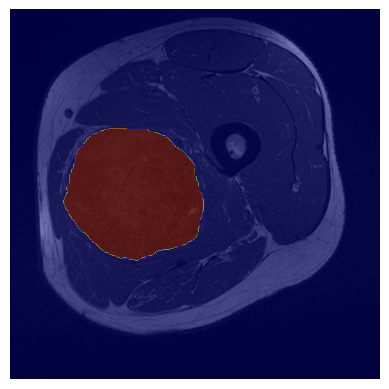

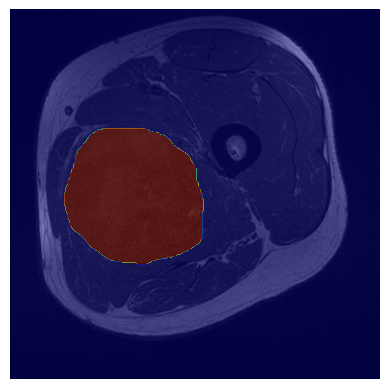

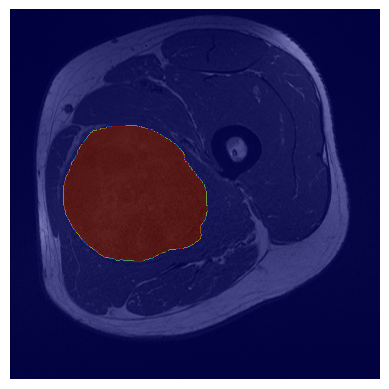

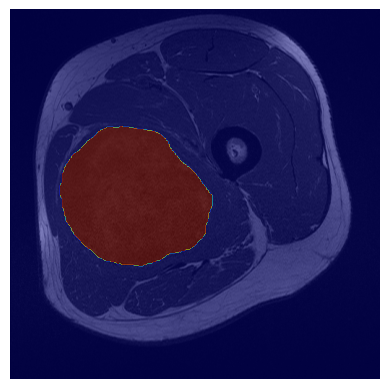

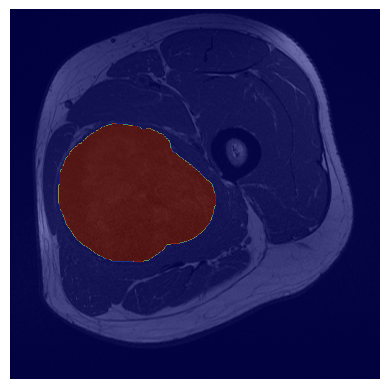

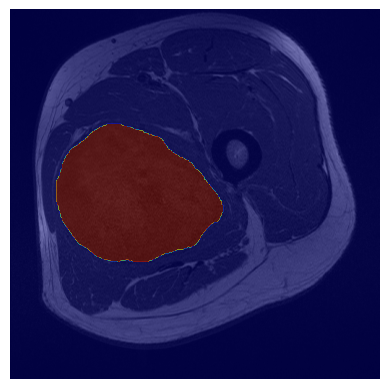

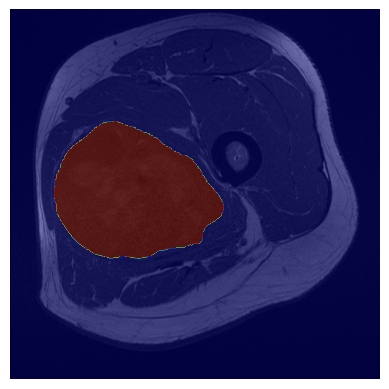

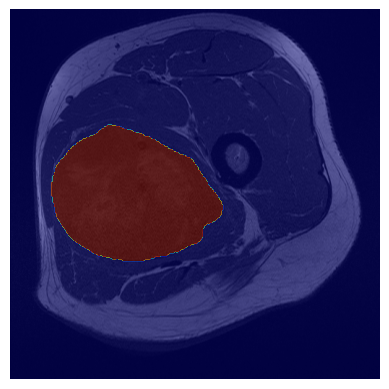

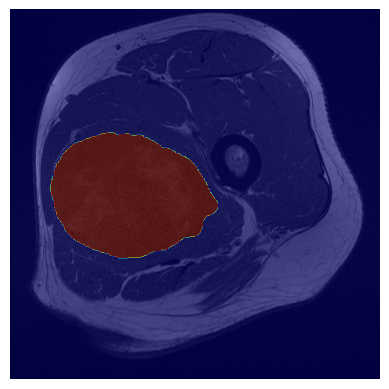

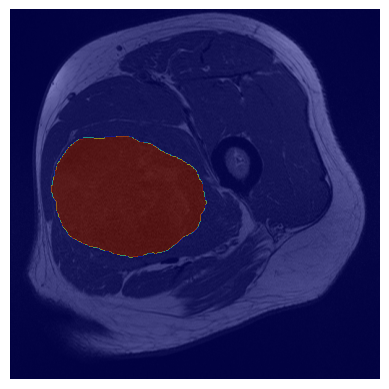

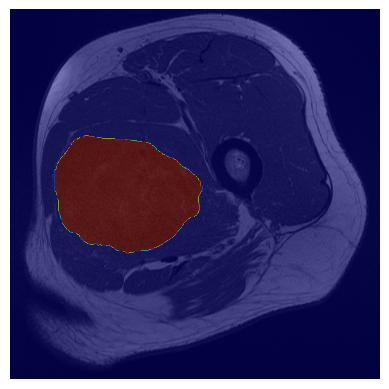

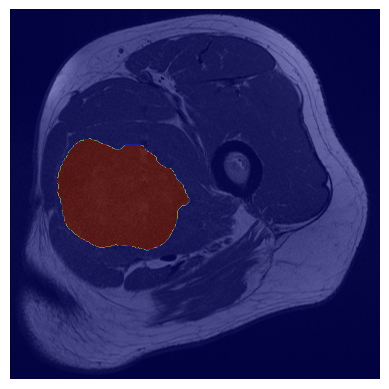

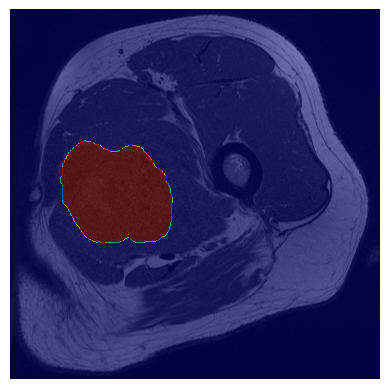

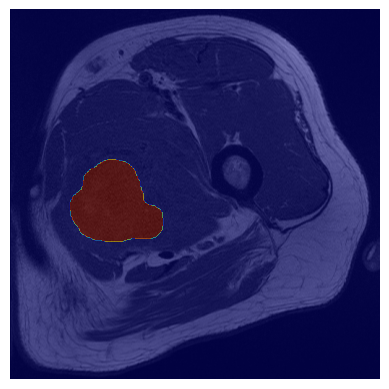

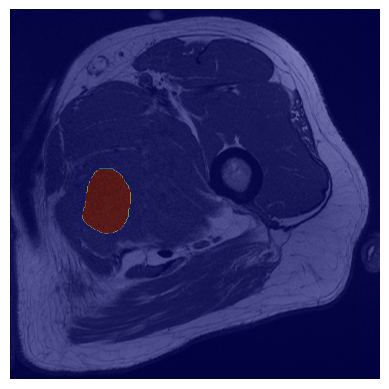

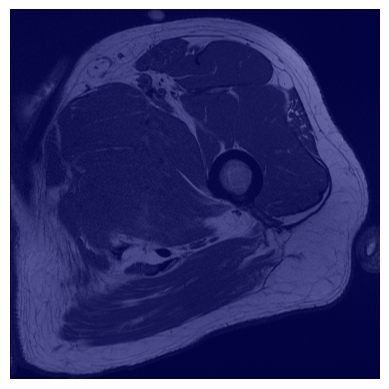

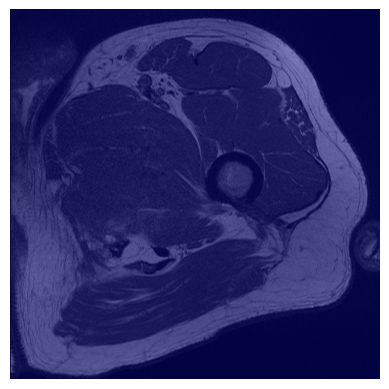

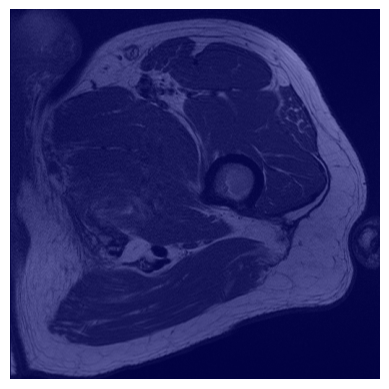

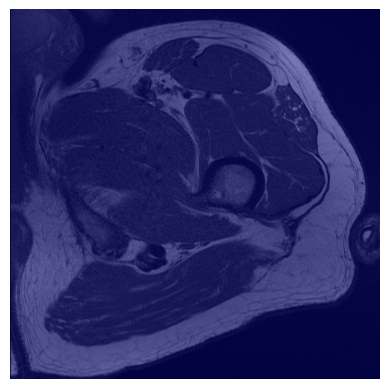

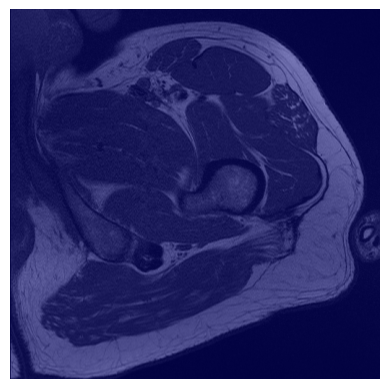

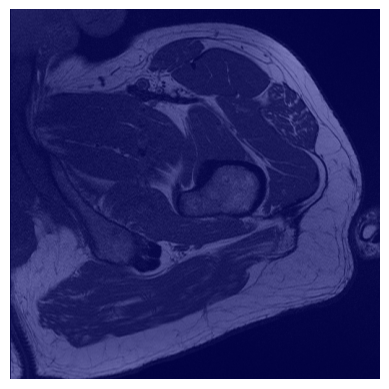

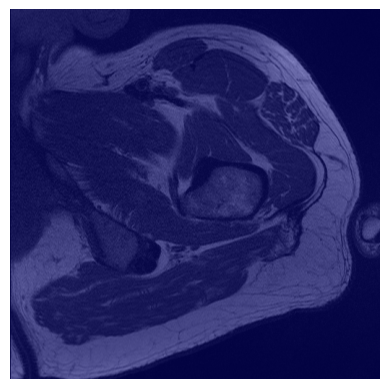

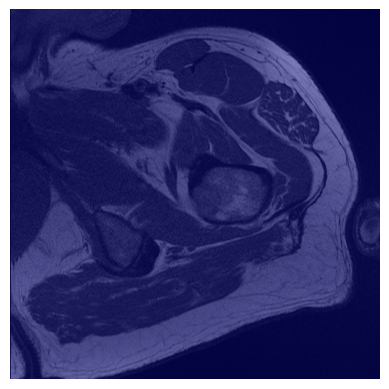

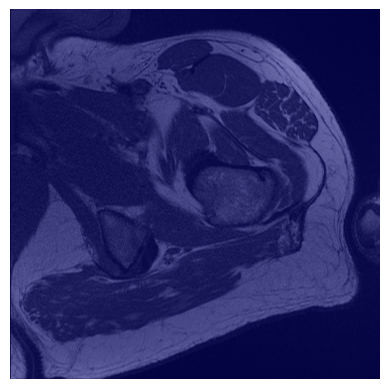

In [6]:
# Load existing RT Struct. Requires the series path and existing RT Struct path
rtstruct = RTStructBuilder.create_from(
  dicom_series_path=dicom_dir[:-1], 
  rt_struct_path=rtstruct_dir
)

# View all of the ROI names from within the image
print(rtstruct.get_roi_names())
# Loading the 3D Mask from within the RT Struct
mask_3d = rtstruct.get_roi_mask_by_name("GTV_Mass")


# Get a list of all DICOM files in the directory
image_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
# sort the image_files by their name
image_files.sort(reverse=True)
# Now you can load the DICOM images
images = {pydicom.dcmread(f).SOPInstanceUID: pydicom.dcmread(f) for f in image_files}


# Display all slices of the region
for i in range(mask_3d.shape[2]):
    uid = list(images.keys())[i]  # get the SOPInstanceUID of the ith image
    plt.imshow(images[uid].pixel_array, cmap='gray') # plot the ith image

    mask_slice = mask_3d[:, :, i]
    plt.imshow(mask_slice, cmap='jet', alpha=0.5) # overlay the mask with transparency
    plt.axis('off')
    plt.show()

--- 

---

# Start

## Function to load single RTStruct file and correspondin images 
Returns an array that contains the array of dcm images and it's corresponding array of mask

In [7]:
def load_data(dicom_dir, rtstruct_dir):
    # Load existing RT Struct. Requires the series path and existing RT Struct path
    rtstruct = RTStructBuilder.create_from(
    dicom_series_path=dicom_dir[:-1], 
    rt_struct_path=rtstruct_dir
    )

    # View all of the ROI names from within the image
    print(rtstruct.get_roi_names())
    # Loading the 3D Mask from within the RT Struct
    mask_3d = rtstruct.get_roi_mask_by_name("GTV_Mass")


    # Get a list of all DICOM files in the directory
    image_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    # sort the image_files by their name
    image_files.sort(reverse=True)
    # Now you can load the DICOM images
    images = {pydicom.dcmread(f).SOPInstanceUID: pydicom.dcmread(f) for f in image_files}

    return images, mask_3d

## Load dataset
This creates a dictionary to store each patient and their corresponding path of each RTStruct (Mask) with it's corresponding folder path of images

In [63]:
def extract_ds(root_dir, file_extension=".dcm"):
    # create a dictionary with the patient's id as key and an empty dictionary as value
    patient_images = {f"dataset/Soft-tissue-Sarcoma/STS_{i:03d}": {} for i in range(1, 11)}

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Get the parent directory of 'root'
            parent_dir = os.path.dirname(root)
            # Get the grandparent directory of 'root' which is the patient's id
            grandparent_dir = os.path.dirname(parent_dir)

            # checks if dir contains string "RTstruct" and "T1toPET"
            if 'RTstruct' in os.path.basename(root) and 'T1toPET' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1toPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1toPET'] = {}

                patient_images[grandparent_dir][parent_dir]['T1toPET']['mask'] = os.path.join(root,'1-1.dcm')

            # checks if dir contains string "RTstruct" and "T2FStoPET"
            elif 'RTstruct' in os.path.basename(root) and 'T2FStoPET' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2FStoPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2FStoPET'] = {}

                patient_images[grandparent_dir][parent_dir]['T2FStoPET']['mask'] = os.path.join(root,'1-1.dcm')

            # checks if dir contains string "RTstruct" and "CT"
            elif 'RTstruct' in os.path.basename(root) and 'CT' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'CT' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['CT'] = {}

                patient_images[grandparent_dir][parent_dir]['CT']['mask'] = os.path.join(root,'1-1.dcm')

            # checks if dir contains string "RTstruct" and "PET"
            elif 'RTstruct' in os.path.basename(root) and 'PET' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'PET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['PET'] = {}

                patient_images[grandparent_dir][parent_dir]['PET']['mask'] = os.path.join(root,'1-1.dcm')

            elif 'RTstruct' in os.path.basename(root) and 'T1' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1'] = {}

                patient_images[grandparent_dir][parent_dir]['T1']['mask'] = os.path.join(root,'1-1.dcm')
            
            # checks if dir contains string "RTstruct" and "T2"
            elif 'RTstruct' in os.path.basename(root) and 'T2' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2'] = {}

                patient_images[grandparent_dir][parent_dir]['T2']['mask'] = os.path.join(root,'1-1.dcm')

            # checks if dir contains string "T1toPET"
            elif 'T1toPET' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1toPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1toPET'] = {}

                patient_images[grandparent_dir][parent_dir]['T1toPET']['image'] = root
                break

            # checks if dir contains string "T2FStoPET"
            elif 'T2FStoPET' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2FStoPET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2FStoPET'] = {}

                patient_images[grandparent_dir][parent_dir]['T2FStoPET']['image'] = root
                break

            # checks if dir contains string "CT"
            elif 'CT' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'CT' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['CT'] = {}

                patient_images[grandparent_dir][parent_dir]['CT']['image'] = root
                break

            # checks if dir contains string "PET"
            elif 'PET' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'PET' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['PET'] = {}

                patient_images[grandparent_dir][parent_dir]['PET']['image'] = root
                break
            
            # checks if dir contains string "T1"
            elif 'T1' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T1' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T1'] = {}

                patient_images[grandparent_dir][parent_dir]['T1']['image'] = root
                break

            # checks if dir contains string "T2"
            elif 'T2' in os.path.basename(root) and '.' in os.path.basename(root):
                # checks if patient_images[grandparent_dir][parent_dir] is empty
                if parent_dir not in patient_images[grandparent_dir]:
                    patient_images[grandparent_dir][parent_dir] = {}
                if 'T2' not in patient_images[grandparent_dir][parent_dir]:
                    patient_images[grandparent_dir][parent_dir]['T2'] = {}

                patient_images[grandparent_dir][parent_dir]['T2']['image'] = root
                break

    return patient_images



In [64]:
# get the dataset directory dictionary
root_dir = "dataset/Soft-tissue-Sarcoma"
ds_dict = extract_ds(root_dir)

In [65]:
print(ds_dict)

{'dataset/Soft-tissue-Sarcoma/STS_001': {'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929': {'PET': {'image': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-PET AC-51583', 'mask': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructCT-77278/1-1.dcm'}, 'T1toPET': {'mask': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT1toPET-92485/1-1.dcm', 'image': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5436027.000000-AlignedT1toPETBOX-88600'}, 'T2FStoPET': {'mask': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT2FStoPET-36652/1-1.dcm', 'image': 'dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5442056.000000-AlignedT2FStoPETBOX-06608'}}, 'dataset/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623': {'T1': {'image': 'dataset/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623/11.000000-AXIAL SE T1 - RESEARCH

#### Understanding patient_images dictionary

In [66]:
def print_dictionary_tree(dictionary, indent=0):
    for key, value in dictionary.items():
        print('  ' * indent + '- ' + str(key))
        if isinstance(value, dict):
            print_dictionary_tree(value, indent + 1)
        else:
            print('  ' * (indent + 1) + '- ' + str(value))
        
print_dictionary_tree(ds_dict)

- dataset/Soft-tissue-Sarcoma/STS_001
  - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929
    - PET
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-PET AC-51583
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructCT-77278/1-1.dcm
    - T1toPET
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT1toPET-92485/1-1.dcm
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5436027.000000-AlignedT1toPETBOX-88600
    - T2FStoPET
      - mask
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT2FStoPET-36652/1-1.dcm
      - image
        - dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5442056.000000-AlignedT2FStoPETBOX-06608
  - dataset/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623
    - T1
      - image
        - dataset

### Load dataset in memory

In [62]:
def process_dictionary(dictionary, parent_key=''):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            new_key = f'{parent_key}, {key}' if parent_key else key
            process_dictionary(value, parent_key=new_key)
        else:
            if 'image' in dictionary and 'mask' in dictionary:
                patient_key = parent_key.split('/')[-3]
                date_key = parent_key.split('/')[-2]
                image_value = dictionary['image']
                mask_value = dictionary['mask']
                print(f"Patient: {patient_key}, Date: {date_key}, Type: {key}, Image: {image_value}, Mask: {mask_value}")

process_dictionary(ds_dict)

Patient: Soft-tissue-Sarcoma, Date: STS_001, Type: image, Image: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-PET AC-51583, Mask: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructCT-77278/1-1.dcm
Patient: Soft-tissue-Sarcoma, Date: STS_001, Type: mask, Image: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-PET AC-51583, Mask: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructCT-77278/1-1.dcm
Patient: Soft-tissue-Sarcoma, Date: STS_001, Type: mask, Image: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5436027.000000-AlignedT1toPETBOX-88600, Mask: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/1.000000-RTstructAlignedT1toPET-92485/1-1.dcm
Patient: Soft-tissue-Sarcoma, Date: STS_001, Type: image, Image: dataset/Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PET CT-63929/5436027.000000-AlignedT1toPETBOX-88600, Mask: dataset/Soft-tissue-Sarcoma/STS_001/0